In [1]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from diffusers import DDPMPipeline

import datasets
from datasets import load_dataset

from utils.motionblur import Kernel
from utils.utils_img import fft_blur, clean_output, tensor2uint
from utils.scheduler import NewDDPMScheduler, NewDDPMSchedulerOutput
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
cache_dir = '/Data/dheurtel/cache'

/users/eleves-a/2020/david.heurtel-depeiges/Desktop/ALTeGraD23_Data_Challenge/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tracing = False
half = True

if half:
    torch.set_default_tensor_type(torch.HalfTensor)

model_name="google/ddpm-ema-celebahq-256" # 256x256 8 iteratons/second
model_name="basilevh/ddpm-ema-flowers-256-noac"

ddpm = DDPMPipeline.from_pretrained(model_name, cache_dir=cache_dir,torch_dtype=torch.float16).to(device)
ddpm.unet = ddpm.unet.eval()

datasets.config.DOWNLOADED_DATASETS_PATH = Path("/Data/datasets")
dataset = load_dataset("huggan/flowers-102-categories", cache_dir=cache_dir, split="train")

checkpoint-27000/model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


In [3]:
#image = ddpm(num_inference_steps=200).images[0]
#image

In [4]:
initial_scheduler = ddpm.scheduler
new_scheduler = NewDDPMScheduler(**initial_scheduler.config)

num_time_steps = 200

new_scheduler.set_timesteps(num_time_steps)

model = ddpm.unet
model.scheduler = new_scheduler

In [5]:
def scheduler_alpha_t(scheduler, t):
    # Get \bar\alpha_t and \alpha_t from scheduler
    #   t should be an integer between 0 and T
    #   T = scheduler.num_train_timesteps # 1000
    prev_t = scheduler.previous_timestep(t)
    alpha_prod_t = scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
    #beta_prod_t = 1 - alpha_prod_t
    #beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    #current_beta_t = 1 - current_alpha_t
    return alpha_prod_t, current_alpha_t

def scheduler_alphas(scheduler):
    T = scheduler.num_inference_steps # 1000
    stride=1
    n = T #math.ceil((T+1)/stride)
    alpha = torch.zeros(n)
    alpha_bar = torch.zeros(n)
    time = torch.zeros(n)
    for t in range(0,T,stride):
        alpha_prod_t, current_alpha_t = scheduler_alpha_t(scheduler, t)
        #beta_prod_t = 1 - alpha_prod_t
        #current_beta_t = 1 - current_alpha_t
        #bt = current_beta_t / torch.sqrt(current_alpha_t)
        alpha[t] = current_alpha_t
        alpha_bar[t] = alpha_prod_t
        time[t] = t
    return alpha, alpha_bar, time

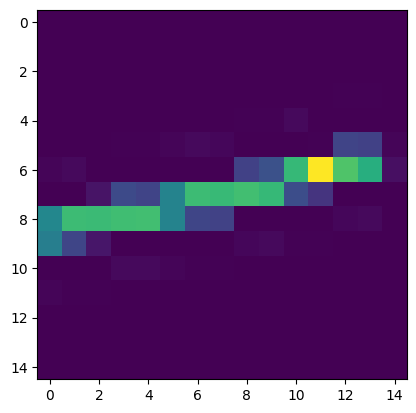

In [6]:
kernel = Kernel(size=(15,15), intensity=0.5)

plt.imshow(kernel.kernelMatrix)

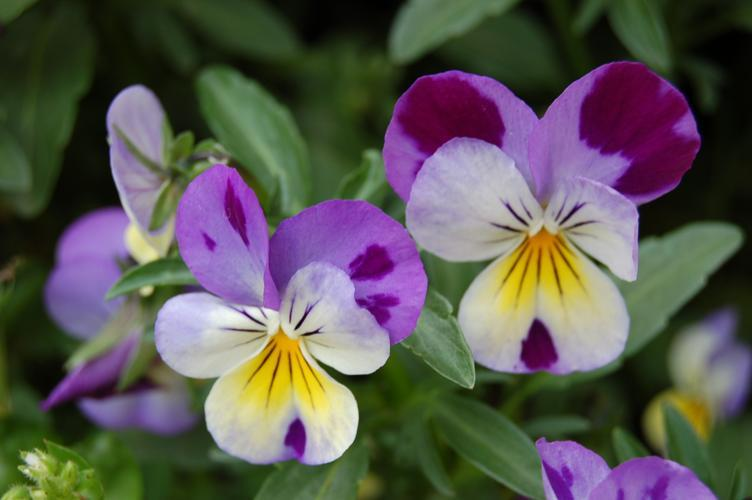

In [7]:
## Img from PIL to torch
pil_img = dataset[0]["image"]
pil_img

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [9]:
img = transform(pil_img)
img.shape

k = torch.tensor(kernel.kernelMatrix)

In [10]:
sigma_y = 0.03

In [11]:
blurry_img = fft_blur(img.to(torch.float32), k.unsqueeze(0).unsqueeze(0)).to(torch.float16) + sigma_y*torch.randn_like(img)

In [12]:
def clamp(tensor, min_val, max_val):
    return torch.max(torch.min(tensor, max_val*torch.ones_like(tensor)), min_val*torch.ones_like(tensor))

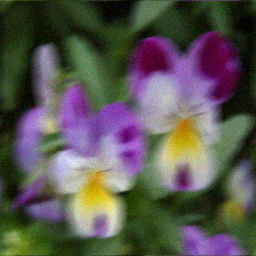

In [13]:
pil_blurry_img = transforms.ToPILImage()(clamp(blurry_img[0], 0., 1.))
pil_blurry_img

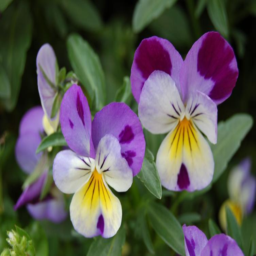

In [14]:
pil_img = transforms.ToPILImage()(img)
pil_img

In [15]:
def alpha_beta(scheduler, t):
    prev_t = scheduler.previous_timestep(t)
    alpha_prod_t = scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t
    current_alpha_prod_t = alpha_prod_t
    next_alpha_prod_t = alpha_prod_t_prev
    return current_alpha_t, current_beta_t, current_alpha_prod_t, next_alpha_prod_t

In [16]:
# DPS with DDPM and intrinsic scale
def dps_sampling(model, nsamples, observation, forward_log_likelihood, scheduler, verbose = False, eta=1.0,time_rescaling=False, display_intermediary=False):
    sample_size = model.config.sample_size
    for param in model.parameters():
        param.requires_grad = False
    # Init random noise
    x_T = torch.randn((nsamples, 3, sample_size, sample_size)).to(device)
    x_t = x_T
    count = 0
    length = len(scheduler.timesteps)
    print_every = length // 20
    for t in tqdm.tqdm(scheduler.timesteps, disable=not verbose):
        
        # Predict noisy residual eps_theta(x_t)
        x_t.requires_grad_()
        epsilon_t = model(x_t, t).sample

        # Get x0_hat and unconditional 
        # x_{t-1} = a_t * x_t + b_t * epsilon(x_t) + sigma_t z_t
        # with b_t = eta_t
        predict = scheduler.step(epsilon_t, t, x_t) 
        x0_hat  = clean_output(predict.pred_original_sample)
        x_prev  = predict.prev_sample # unconditional DDPM sample x_{t-1}'
        alpha_t, beta_t, alpha_prod, next_alpha_prod = alpha_beta(scheduler, t)
        # Guidance
        #f = torch.norm(forward_model(x0_hat) - y)**2/2/(sigma_y**2+(1-alpha_prod)/eta)
        #g = torch.autograd.grad(f, x_t)[0]
        rescaling_factor = time_rescaling * (1-alpha_prod)/eta
        quadratic, constant, log_factor = forward_log_likelihood(x0_hat, observation, rescaling_factor)
        g = -quadratic/constant - log_factor
        guidance = torch.autograd.grad(g.sum(), x_t)[0]
        # Guidance weight
        # eta_t = ...
        eta_t =  beta_t / torch.sqrt(alpha_t)

        # DPS update rule = DDPM update rule + guidance
        x_t = x_prev - eta_t * guidance
        x_t = x_t.detach_()

        if count % print_every == 0 and display_intermediary:
            # Show progress of the sampling
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(tensor2uint(x_t[0]))
            ax[0].axis('off')
            ax[0].set_title('t = %d' % t)
            ax[1].imshow(tensor2uint(x0_hat[0]))
            ax[1].axis('off')
            ax[1].set_title('t = %d' % t)
            plt.show()
        count += 1

    return clean_output(x_t)

In [17]:
forward_model = lambda x: fft_blur(x.to(torch.float32), k.unsqueeze(0).unsqueeze(0).to(x.device)).to(torch.float16) 

def forward_log_likelihood(x, y, rescaling_factor):
    ndim = x.shape[1:].numel()
    return - torch.sum((forward_model(x)-y)**2, dim=(1,2,3)),2*(sigma_y**2+rescaling_factor) ,- np.log(sigma_y**2+rescaling_factor)*ndim/2

In [18]:
model = model.to(device)
nsamples = 2

In [19]:
#res = dps_sampling(model, nsamples, blurry_img.to(device), forward_log_likelihood, new_scheduler, verbose = True, eta=1.0,time_rescaling=True, display_intermediary=False)

In [20]:
#pil_res = transforms.ToPILImage()(res[1])
#pil_res

In [21]:
# DPS with DDPM and intrinsic scale
def dps_sampling_batch(model, nsamples, observation, forward_log_likelihood, scheduler, verbose = False, eta=1.0,time_rescaling=False, display_intermediary=False, batch_size=6):
    sample_size = model.config.sample_size
    for param in model.parameters():
        param.requires_grad = False
    # Init random noise
    x_t = torch.randn((nsamples, 3, sample_size, sample_size)).to(device)
    count = 0
    length = len(scheduler.timesteps)
    print_every = length // 20
    for t in tqdm.tqdm(scheduler.timesteps, disable=not verbose):
        alpha_t, beta_t, alpha_prod, next_alpha_prod = alpha_beta(scheduler, t)
        # Guidance weight
        # eta_t = ...
        eta_t =  beta_t / torch.sqrt(alpha_t)
        # Predict noisy residual eps_theta(x_t)
        for i in range(0, nsamples, batch_size):
            xtemp = x_t[i:min(i+batch_size, nsamples)].clone().detach().requires_grad_()
            epsilon_t = model(xtemp, t).sample

            # Get x0_hat and unconditional 
            # x_{t-1} = a_t * x_t + b_t * epsilon(x_t) + sigma_t z_t
            # with b_t = eta_t
            predict = scheduler.step(epsilon_t, t, xtemp) 
            x0_hat  = clean_output(predict.pred_original_sample)
            x_prev  = predict.prev_sample

            # Guidance
            rescaling_factor = time_rescaling * (1-alpha_prod)/eta
            g = - forward_log_likelihood(x0_hat, observation, rescaling_factor)
            guidance = torch.autograd.grad(g.sum(), xtemp)[0]
            # DPS update rule = DDPM update rule + guidance
            with torch.no_grad():
                x_t[i:min(i+batch_size, nsamples)] = x_prev - eta_t * guidance
                x_t = x_t.detach_()

        if count % print_every == 0 and display_intermediary:
            # Show progress of the sampling
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(tensor2uint(x_t[0]))
            ax[0].axis('off')
            ax[0].set_title('t = %d' % t)
            ax[1].imshow(tensor2uint(x0_hat[0]))
            ax[1].axis('off')
            ax[1].set_title('t = %d' % t)
            plt.show()
        count += 1

    return clean_output(x_t)

In [22]:
#res = dps_sampling_batch(model, 32, blurry_img.to(device), forward_log_likelihood, scheduler, verbose = True, eta=1.0,time_rescaling=True, display_intermediary=False, batch_size=16)

**Remark** This implementation computes most quantities in a batched manner, with some memory manipulations (clone, detach that clears the computation graph) to limit memory usage. All these quantities could be computed in parallel on several GPUs. That being said on a single GPU, like ours, quick profiling shows that the bottleneck of computations is not these memory manipulations but the sheer number of FLOPs required by the foward and backward passes in the network.

In [23]:
#pil_res = transforms.ToPILImage()(res[2])
#pil_res

In [24]:
# DPS with DDPM and intrinsic scale
def tds_sampling_batch(model, nsamples, observation, forward_log_likelihood, scheduler, verbose = False, eta=1.0,time_rescaling=False,
                      batch_size=6,threshold_resampling = 0.9, return_auxiliary = False, eta_schedule = None):
    sample_size = model.config.sample_size
    for param in model.parameters():
        param.requires_grad = False

    display = np.linspace(0, len(scheduler.timesteps)-1, 5).astype(int)
    # Init random noise
    x_t = torch.randn((nsamples, 3, sample_size, sample_size)).to(device)

    t = scheduler.timesteps[0]

    ## Precompute some term for loop initialization
    alpha_t, beta_t, alpha_prod, next_alpha_prod = alpha_beta(scheduler, t)
    eta_t =  beta_t / torch.sqrt(alpha_t)
    guidance_all = torch.zeros_like(x_t)
    epsilon_all = torch.zeros_like(x_t)
    log_p_obs_given_x_t_quadratic = torch.zeros(nsamples).to(device)
    log_p_obs_given_x_t_constant = 1
    log_p_obs_given_x_t_log_factor = 0
    if eta_schedule is not None:
        eta = eta_schedule[0]
    for i in range(0, nsamples, batch_size):
        xtemp = x_t[i:min(i+batch_size, nsamples)].clone().detach().requires_grad_()
        epsilon_t = model(xtemp, t).sample
        epsilon_all[i:min(i+batch_size, nsamples)] = epsilon_t.detach().clone()
        predict = scheduler.step(epsilon_t, t, xtemp)
        x0_hat  = clean_output(predict.pred_original_sample)
        # Guidance
        rescaling_factor = time_rescaling * (1-alpha_prod)/eta
        quadratic, constant, log_factor = forward_log_likelihood(x0_hat.to(torch.float32), observation.to(torch.float32), rescaling_factor)
        #ll = quadratic/constant + log_factor
        #guidance = torch.autograd.grad(-ll.sum(), xtemp)[0]
        guidance = torch.autograd.grad(-quadratic.sum(), xtemp)[0]/constant #helps with numerical stability (most of the time)
        guidance_all[i:min(i+batch_size, nsamples)] = guidance.detach().clone()
        log_p_obs_given_x_t_quadratic[i:min(i+batch_size, nsamples)] = quadratic.detach().clone()
        log_p_obs_given_x_t_constant = constant
        log_p_obs_given_x_t_log_factor = log_factor
    log_weights = (log_p_obs_given_x_t_quadratic.clone()/log_p_obs_given_x_t_constant).to(torch.float32) #We can ignore the log_factor term here only (usefull for numerical stability)
    ess_list = []
    all_timesteps = scheduler.timesteps
    nsteps = len(all_timesteps)-1
    for i in tqdm.tqdm(range(nsteps), disable=not verbose):
        with torch.no_grad():
            weights = torch.softmax(log_weights, dim=0)
            ess = 1/torch.sum(weights**2)
            ess_list.append(ess.item())
            if ess < threshold_resampling * nsamples:
                idx = torch.multinomial(weights, nsamples, replacement=True)
                x_t = x_t[idx]
                log_p_obs_given_x_t_quadratic = log_p_obs_given_x_t_quadratic[idx]
                epsilon_all = epsilon_all[idx]
                guidance_all = guidance_all[idx]
                log_weights = torch.zeros(nsamples).to(device).to(torch.float32)
            ## Now diffusion step
            t = all_timesteps[i]
            predict = scheduler.step(epsilon_all, t , x_t)
            x_prev  = predict.prev_sample
            x_prev_mean = predict.mean_prev_sample

            x_prev = x_prev - eta_t * guidance_all

            var_diffusion = scheduler._get_variance(t)
            log_p_non_cond_log_p_cond = - torch.sum(eta_t*guidance_all*(2*(x_prev - x_prev_mean) + eta_t*guidance_all),dim=(1,2,3)).to(torch.float32)/(2*var_diffusion)
            log_p_obs_given_old_quadratic = log_p_obs_given_x_t_quadratic.clone()
            log_p_obs_given_old_constant = log_p_obs_given_x_t_constant
            log_p_obs_given_old_log_factor = log_p_obs_given_x_t_log_factor
   
        x_t = x_prev.clone().detach()

        t = all_timesteps[i+1]
        alpha_t, beta_t, alpha_prod, next_alpha_prod = alpha_beta(scheduler, t)
        eta_t =  beta_t / torch.sqrt(alpha_t)

        ## Compute terms for next step
        if eta_schedule is not None:
            eta = eta_schedule[i+1]
        
        for i_b in range(0, nsamples, batch_size):
            xtemp = x_t[i_b:min(i_b+batch_size, nsamples)].clone().detach().requires_grad_()
            epsilon_t = model(xtemp, t).sample
            epsilon_all[i_b:min(i_b+batch_size, nsamples)] = epsilon_t.detach().clone()
            predict = scheduler.step(epsilon_t, t, xtemp)
            x0_hat  = clean_output(predict.pred_original_sample)
            # Guidance
            rescaling_factor = time_rescaling * (1-alpha_prod)/eta
            quadratic, constant, log_factor = forward_log_likelihood(x0_hat, observation, rescaling_factor)
            #ll = quadratic/constant + log_factor
            #guidance = torch.autograd.grad(-ll.sum(), xtemp)[0]
            guidance = torch.autograd.grad(-quadratic.sum(), xtemp)[0]/constant #helps with numerical stability (most of the time)
            guidance_all[i_b:min(i_b+batch_size, nsamples)] = guidance.detach().clone()
            log_p_obs_given_x_t_quadratic[i_b:min(i_b+batch_size, nsamples)] = quadratic.detach().clone()
            log_p_obs_given_x_t_constant = constant
            log_p_obs_given_x_t_log_factor = log_factor

        log_weights+= log_p_non_cond_log_p_cond
        #log_weights+= (log_p_obs_given_x_t - log_p_obs_given_old).to(torch.float32)
        #print(log_p_obs_given_x_t_quadratic, log_p_obs_given_x_t_constant, log_p_obs_given_x_t_log_factor)
        diff_log_p_obs = 1/log_p_obs_given_x_t_constant * (log_p_obs_given_x_t_quadratic - log_p_obs_given_old_quadratic*(log_p_obs_given_x_t_constant/log_p_obs_given_old_constant)).to(torch.float32)
        #diff_log_p_obs += (log_p_obs_given_x_t_log_factor - log_p_obs_given_old_log_factor) #We can ignore the log_factor term here only (but can be usefull for numerical stability)
        log_weights += diff_log_p_obs
        if log_weights.isnan().any():
            print('Nan detected')
            print(diff_log_p_obs, log_p_non_cond_log_p_cond)
            break
        if log_weights.isinf().all():
            print('Inf detected')
            print(diff_log_p_obs, log_p_non_cond_log_p_cond)
            break
        if i in display:
            # Show progress of the sampling
            fig, ax = plt.subplots(1, 4, figsize=(20, 5))
            ax[0].imshow(tensor2uint(x_t[0]))
            ax[0].axis('off')
            ax[0].set_title('t = %d' % t)
            ax[1].imshow(tensor2uint(x0_hat[0]))
            ax[1].axis('off')
            ax[1].set_title('t = %d' % t)
            ax[2].imshow(tensor2uint(blurry_img[0]))
            ax[2].axis('off')
            ax[2].set_title('Observation')
            ax[3].imshow(tensor2uint(img))
            ax[3].axis('off')
            ax[3].set_title('Ground truth')
            plt.show()
    weights = torch.softmax(log_weights, dim=0)
    ess_list.append(1/(weights**2).sum().item())
    idx = torch.multinomial(weights, sample_size, replacement=True)
    if return_auxiliary:
        return clean_output(x_t[idx]), ess_list#, memory_samples, ratio
    return clean_output(x_t[idx])

In [25]:
nsamples = 32
batch_size = 16

In [26]:
## Eta schedule in three parts
## linear from 0.05 to 0.01 in 100 steps
## constant at 0.01 for 50 step
## linear from 0.01 to 1 in 50 steps

#eta_schedule = torch.cat([torch.linspace(0.05, 0.03, 70), torch.ones(50)*0.03, torch.linspace(0.03, 0.3, 80)])
#eta_schedule = torch.linspace(0.03, 0.5, len(new_scheduler.timesteps))
eta_schedule = torch.cat([torch.ones(40)*0.04, torch.linspace(0.04, 0.1, 80), torch.ones(80)*0.1])
eta_schedule = eta_schedule.numpy()

  0%|          | 0/199 [00:00<?, ?it/s]

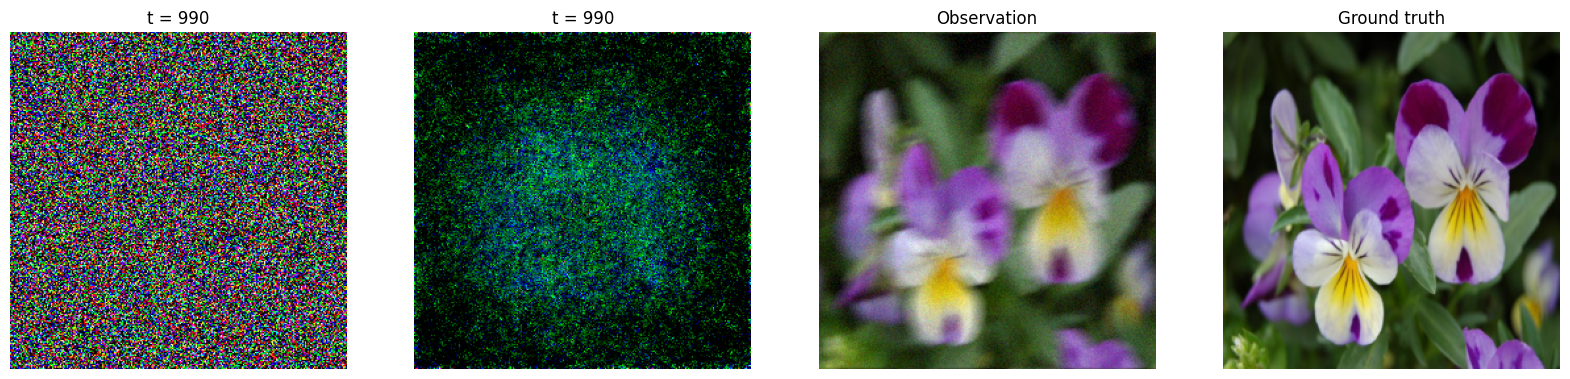

 25%|██▍       | 49/199 [00:46<02:20,  1.07it/s]

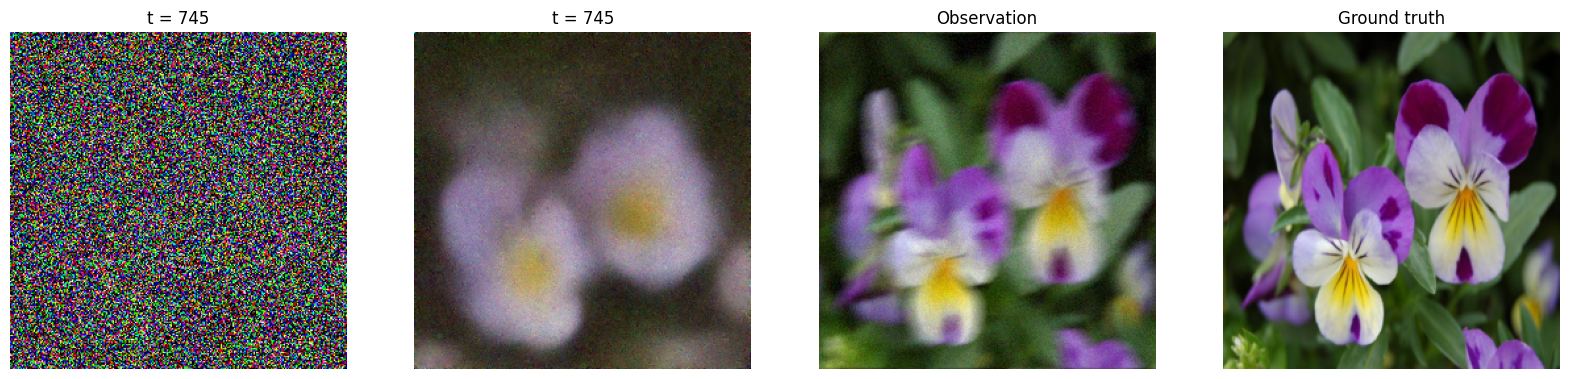

 50%|████▉     | 99/199 [01:33<01:34,  1.06it/s]

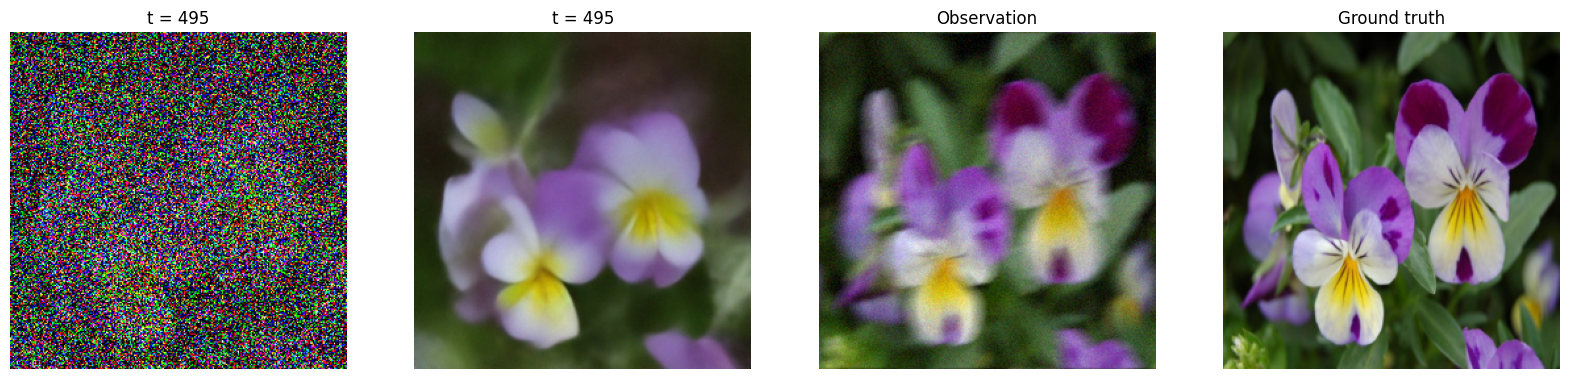

 75%|███████▍  | 149/199 [02:20<00:47,  1.06it/s]

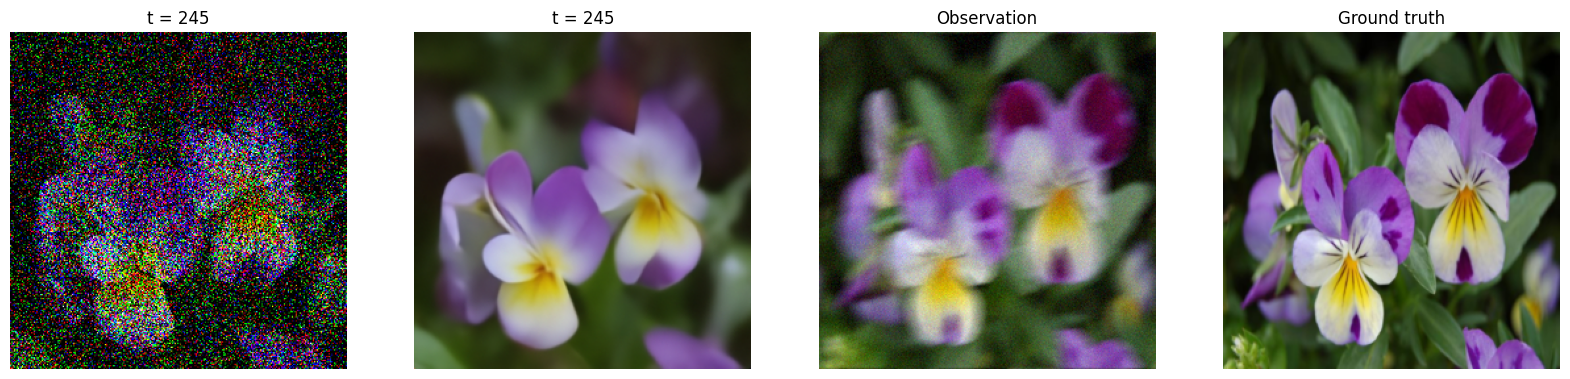

100%|██████████| 199/199 [03:08<00:00,  1.06it/s]


In [27]:
#eta_schedule = None
res, ess_list = tds_sampling_batch(model, nsamples, blurry_img.to(device), forward_log_likelihood, new_scheduler, verbose = True, eta=0.3,time_rescaling=True,
                      batch_size=batch_size,threshold_resampling = 0.9, return_auxiliary = True, eta_schedule = eta_schedule)

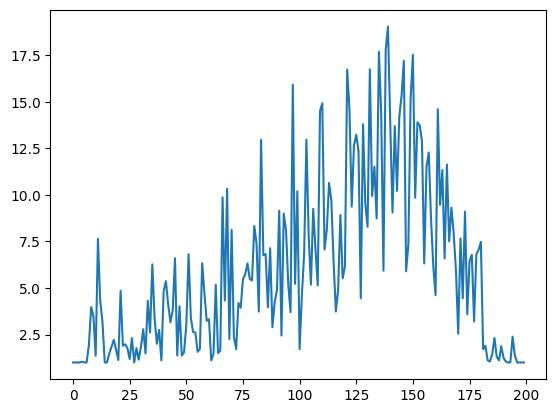

In [28]:
plt.plot(ess_list)

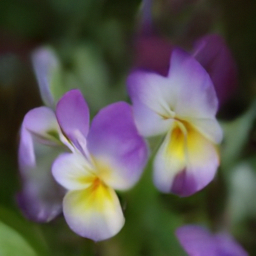

In [29]:
pil_res = transforms.ToPILImage()(res[1])
pil_res